In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

import seaborn as sns

import shap
shap.initjs()

from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#import dataset
data = pd.read_csv("dataset\ILPD\ilpd.csv").dropna()
data['class'] = data['class'].apply(lambda x: 0 if x == 2 else x)


In [3]:
data.columns

Index(['Age', 'Gender', 'Total Bilirubin', 'Direct Bilirubin',
       'Alkaline Phosphotase', 'SGPT (Alanine Aminotransferase)',
       'SGOT (Aspartate Transaminase)', 'Total Proteins', 'Albumin',
       'A/G Ratio', 'class'],
      dtype='object')

In [4]:
data.head()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Alkaline Phosphotase,SGPT (Alanine Aminotransferase),SGOT (Aspartate Transaminase),Total Proteins,Albumin,A/G Ratio,class
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [8]:
corr_mat = data.drop(['class', 'Gender'], axis=1).corr()

In [9]:
corr_mat

,Age,Total Bilirubin,Direct Bilirubin,Alkaline Phosphotase,SGPT (Alanine Aminotransferase),SGOT (Aspartate Transaminase),Total Proteins,Albumin,A/G Ratio
Age,1.000000,0.011000,0.006784,0.078878,-0.087799,-0.020499,-0.186248,-0.264211,-0.216408
Total Bilirubin,0.011000,1.000000,0.874481,0.205739,0.213375,0.237323,-0.007906,-0.222087,-0.206267
Direct Bilirubin,0.006784,0.874481,1.000000,0.234008,0.233180,0.257022,0.000033,-0.228409,-0.200125
Alkaline Phosphotase,0.078878,0.205739,0.234008,1.000000,0.124777,0.166580,-0.027062,-0.163419,-0.234166
SGPT (Alanine Aminotransferase),-0.087799,0.213375,0.233180,0.124777,1.000000,0.791862,-0.042432,-0.028658,-0.002375
SGOT (Aspartate Transaminase),-0.020499,0.237323,0.257022,0.166580,0.791862,1.000000,-0.025751,-0.084915,-0.070040
Total Proteins,-0.186248,-0.007906,0.000033,-0.027062,-0.042432,-0.025751,1.000000,0.783112,0.234887
Albumin,-0.264211,-0.222087,-0.228409,-0.163419,-0.028658,-0.084915,0.783112,1.000000,0.689632
A/G Ratio,-0.216408,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000


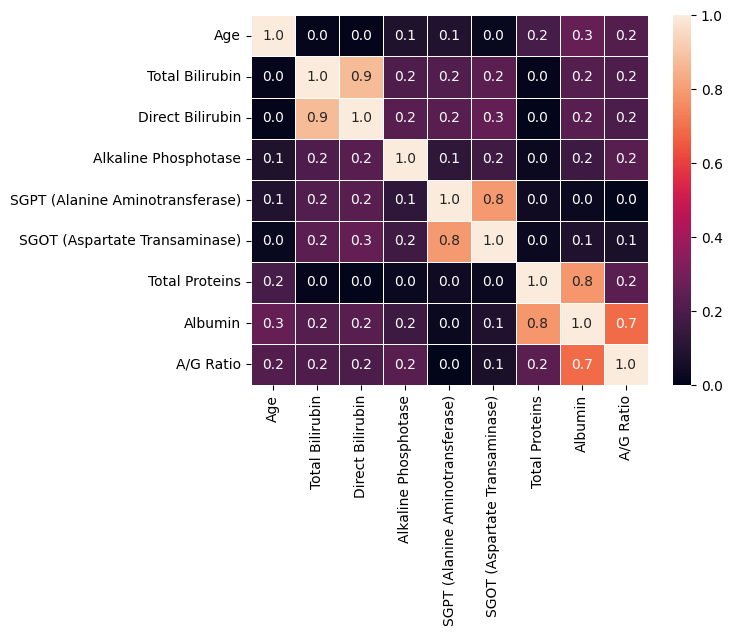

In [10]:
sns.heatmap(
    abs(corr_mat), annot=True, fmt=".1f", linewidth=.5, vmin=0, vmax=1
)
plt.savefig('output/corr.eps')

In [11]:
# Standardize numeric columns (excluding 'class') using StandardScaler
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop('class')
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
                      
#Get features
y = data['class']
X = data.drop('class', axis = 1)

X['Gender'] = X['Gender'].apply(lambda x: 0 if x == 'Male' else 1)

In [12]:
X.head()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Alkaline Phosphotase,SGPT (Alanine Aminotransferase),SGOT (Aspartate Transaminase),Total Proteins,Albumin,A/G Ratio
0,1.247403,1,-0.420320,-0.495414,-0.428870,-0.355832,-0.319111,0.293722,0.203446,-0.147390
1,1.062306,0,1.218936,1.423518,1.675083,-0.093573,-0.035962,0.939655,0.077462,-0.648461
2,1.062306,0,0.640375,0.926017,0.816243,-0.115428,-0.146459,0.478274,0.203446,-0.178707
3,0.815511,0,-0.372106,-0.388807,-0.449416,-0.366760,-0.312205,0.293722,0.329431,0.165780
4,1.679294,0,0.093956,0.179766,-0.395996,-0.295731,-0.177537,0.755102,-0.930414,-1.713237


In [13]:
y.value_counts()

1    414
0    165
Name: class, dtype: int64

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#Train model
model = LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [17]:
#Train model
# model = xgb.XGBRegressor(objective="reg:squarederror") 
# model.fit(X_train, y_train)

In [16]:
prediction = model.predict(X_train).round().astype(int)
accuracy = np.mean(prediction == y_train) * 100
accuracy

73.6501079913607

In [17]:
prediction = model.predict(X_test).round().astype(int)
accuracy = np.mean(prediction == y_test) * 100
accuracy

62.93103448275862

In [18]:
model

LogisticRegression(C=0.1)

In [19]:
list(X_train.columns)

['Age',
 'Gender',
 'Total Bilirubin',
 'Direct Bilirubin',
 'Alkaline Phosphotase',
 'SGPT (Alanine Aminotransferase)',
 'SGOT (Aspartate Transaminase)',
 'Total Proteins',
 'Albumin',
 'A/G Ratio']

In [20]:
#Get shap values
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer(X_train)

Using 463 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/463 [00:00<?, ?it/s]

In [38]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[3], show=False)
plt.savefig('output/shap_waterfall.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


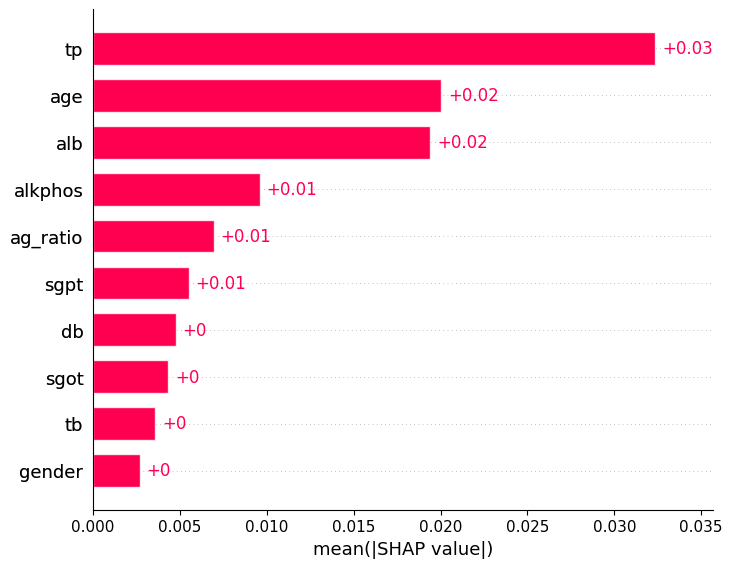

In [36]:
#Mean SHAP
shap.plots.bar(shap_values, show=False)
plt.savefig('output/shap_bar.eps')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


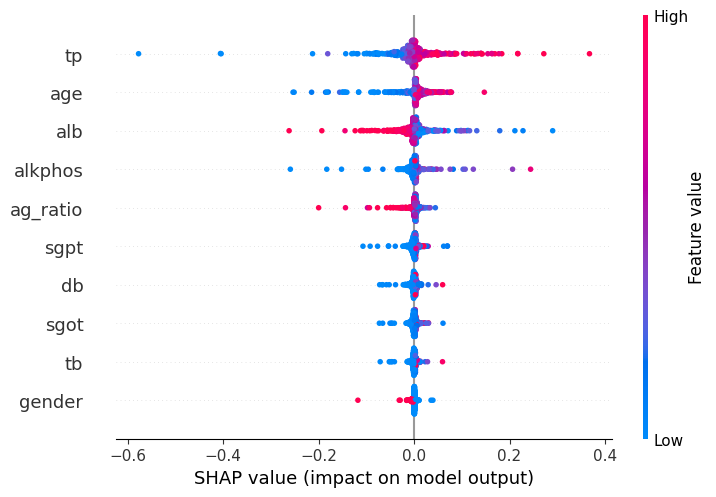

In [35]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, show=False)
# plt.savefig('output/shap_beeswarm.png', dpi = 300, bbox_inches='tight')
plt.savefig('output/shap_beeswarm.eps')